# South-Korea's SEIR

## Instalasi dan Import Library

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
!pip install sobol_seq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sobol_seq
from scipy.optimize import minimize

## Mengambil Data

In [ ]:
# Excel file path and sheet name
file_path = "/content/Simulation_Results_Main_Countries.xlsx"
sheet_name = "South-Korea"

# Call a dataset for data fitting
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first 5 rows
df.head()

,Date,Month,Cum Data,K(t),gamma*E,E,I,R,S,a,Reff
0,16,2,1,16.290462,19.771421,118.628524,19.000000,9.000000,5.126904e+07,1.040848,3.815814
1,17,2,2,36.061245,19.772194,118.633167,36.629674,10.998510,5.126902e+07,0.540042,2.748571
2,18,2,3,72.352458,36.294045,217.764269,61.089340,14.400506,5.126889e+07,2.216990,5.568968
3,19,2,30,133.183563,60.836318,365.017906,103.942726,20.162180,5.126870e+07,2.002124,5.292215
4,20,2,83,227.331680,94.157015,564.942091,171.493197,29.835183,5.126842e+07,1.714982,4.898020


## Mendefinisikan Fungsi

In [ ]:
# SEIR model differential equations
def seir_derivatives(S, E, I, R, t, beta, sigma, gamma):
    dSdt = a*N - beta * S * I / N - mu*S
    dEdt = beta * S * I / N - sigma * E - mu*E
    dIdt = sigma * E - gamma * I - mu*I
    dRdt = gamma * I - mu*R
    return dSdt, dEdt, dIdt, dRdt


# RK4
def ode45_sys(beta, gamma, sigma, E0):
    # Initialize arrays to store results
    S = np.zeros(num_steps)
    E = np.zeros(num_steps)
    I = np.zeros(num_steps)
    R = np.zeros(num_steps)
    time = np.linspace(0, T, num_steps)

    # Initial conditions
    I0 = df["I"][0]
    R0 = 0                  # Initial number of recovered individuals
    S0 = N - I0 - E0 - R0   # Initial number of susceptible individuals
    S[0] = S0
    E[0] = E0
    I[0] = I0
    R[0] = R0

    # RK4 integration
    for i in range(1, num_steps):
        t = time[i - 1]
        dt2 = dt / 2.0

        k1 = np.array(seir_derivatives(S[i - 1], E[i - 1], I[i - 1], R[i - 1], t, beta, sigma, gamma))
        k2 = np.array(seir_derivatives(S[i - 1] + k1[0] * dt2, E[i - 1] + k1[1] * dt2, I[i - 1] + k1[2] * dt2, R[i - 1] + k1[3] * dt2, t + dt2, beta, sigma, gamma))
        k3 = np.array(seir_derivatives(S[i - 1] + k2[0] * dt2, E[i - 1] + k2[1] * dt2, I[i - 1] + k2[2] * dt2, R[i - 1] + k2[3] * dt2, t + dt2, beta, sigma, gamma))
        k4 = np.array(seir_derivatives(S[i - 1] + k3[0] * dt, E[i - 1] + k3[1] * dt, I[i - 1] + k3[2] * dt, R[i - 1] + k3[3] * dt, t + dt, beta, sigma, gamma))

        S[i] = S[i - 1] + (dt / 6.0) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
        E[i] = E[i - 1] + (dt / 6.0) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
        I[i] = I[i - 1] + (dt / 6.0) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
        R[i] = R[i - 1] + (dt / 6.0) * (k1[3] + 2 * k2[3] + 2 * k3[3] + k4[3])
    return [S,E,I,R]


# Define cost function as a squared-error between df["I"] with compartment I in the SIR model
def cost_fun(x):
    beta = x[0]
    gamma = x[1]
    sigma = x[2]
    E0 = x[3]

    # Calculate numerical simulation
    [S,E,I,R] = ode45_sys(beta, gamma, sigma, E0)

    # Calculate the RMSE
    cost = np.sqrt(np.sum((np.array(I) - np.array(df["I"]))**2)/T)
    return cost

## Simulasi dan Optimasi

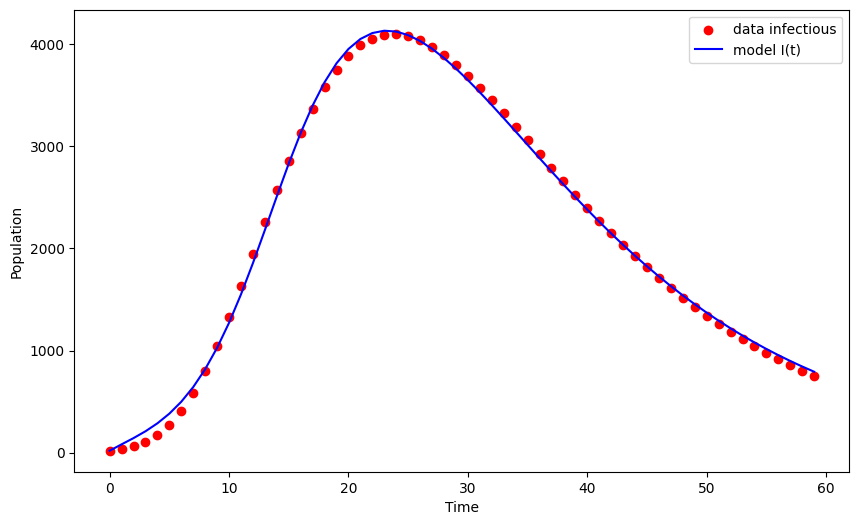



--- Optimal Parameters ---
beta  : 1.252
gamma : 0.070
sigma : 0.110
E0    : 610.717


In [ ]:
# Set parameters that applies to the observed region, e.g. South-Korea
N = 10000         # south-korea's population
T = len(df)     # time for simulation (in days)
dt = 1
num_steps = int(T / dt)
a = 1/(365*70)
mu = 1/(365*70)

# Upper boundaries for (beta, gamma, sigma, E0)
upper_bounds = (3, 1, 1, 1000)

# Selecting good initial guess
nnn = 1000
init_guess = sobol_seq.i4_sobol_generate(4, nnn)
for (i, upper_bound) in enumerate(upper_bounds):
    init_guess[:,i] = init_guess[:,i] * upper_bound

cost_list = [cost_fun(init_guess[f,:]) for f in range(0,nnn)]
min_guess = init_guess[cost_list.index(min(cost_list)),:]

# Optimizing cost_function
bounds = [(0, upper_bound) for upper_bound in upper_bounds]
result = minimize(cost_fun, min_guess, bounds=bounds, method="powell")

optimal_parameters = result.x
[S,E,I,R] = ode45_sys(*optimal_parameters)


# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(T), df["I"], label='data infectious', color="red")
plt.plot(range(T), I, label='model I(t)', color="blue")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Display the optimal parameters
print('\n\n--- Optimal Parameters ---')
print(f'beta  : {optimal_parameters[0]:.3f}')
print(f'gamma : {optimal_parameters[1]:.3f}')
print(f'sigma : {optimal_parameters[2]:.3f}')
print(f'E0    : {optimal_parameters[3]:.3f}')

# Tugas

### Germany

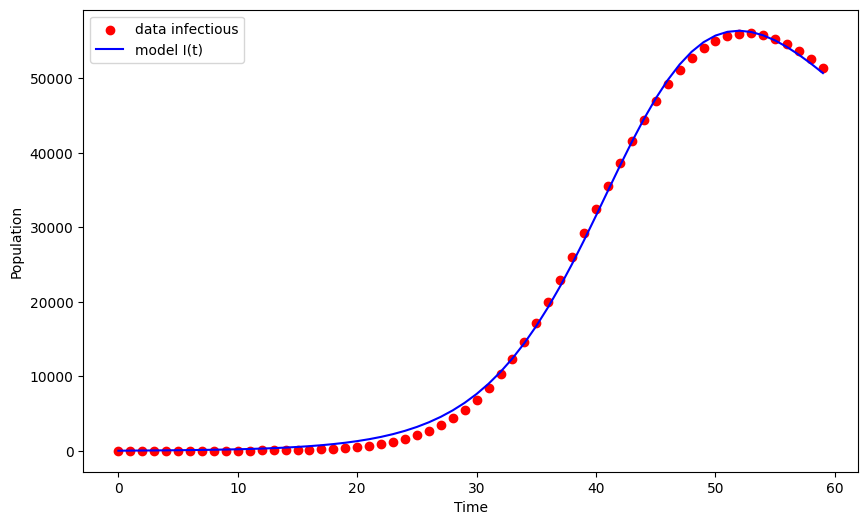



--- Optimal Parameters ---
beta  : 0.330
gamma : 0.039
sigma : 0.392
E0    : 47.051


In [ ]:
# Excel file path and sheet name
file_path = "/content/Simulation_Results_Main_Countries.xlsx"
sheet_name = "Germany"  # (China, Germany, Iran, Italy)

# Set total population N
N = 100000

# Boundary for (beta, gamma, sigma, E0)
upper_bounds = (3, 2, 1, 1000)


### -------------------------------------  ###

# Call a dataset for data fitting
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Set parameters that applies to the observed region
T = len(df)         # time for simulation (in days)
dt = 1
num_steps = int(T / dt)
a = 1/(365*70)
mu = 1/(365*70)


# Selecting good initial guess
print_result = False
nnn = 1000
init_guess = sobol_seq.i4_sobol_generate(4, nnn)
for (i, upper_bound) in enumerate(upper_bounds):
    init_guess[:,i] = init_guess[:,i] * upper_bound

# Optimizing cost_function
cost_list = [cost_fun(init_guess[f,:]) for f in range(0,nnn)]
min_guess = init_guess[cost_list.index(min(cost_list)),:]

print_result = True
bounds = [(0, upper_bound) for upper_bound in upper_bounds]
result = minimize(cost_fun, min_guess, bounds=bounds, method="powell")


# Extract the optimal parameters and SEIR solutions
optimal_parameters = result.x
[S,E,I,R] = ode45_sys(*optimal_parameters)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(T), df["I"], label='data infectious', color="red")
plt.plot(range(T), I, label='model I(t)', color="blue")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Display the optimal parameters
print('\n\n--- Optimal Parameters ---')
print(f'beta  : {optimal_parameters[0]:.3f}')
print(f'gamma : {optimal_parameters[1]:.3f}')
print(f'sigma : {optimal_parameters[2]:.3f}')
print(f'E0    : {optimal_parameters[3]:.3f}')

#### MSE DAN RMSE GERMANY

In [ ]:
#MSE DAN RMSE GERMANY

import numpy as np

# Data observasi (df["I"]) dan data simulasi (I)
observed_data = df["I"]
simulated_data = I

# Menghitung selisih antara data observasi dan hasil simulasi
residuals = observed_data - simulated_data

# Menghitung MSE (Mean Squared Error)
mse = np.mean(residuals ** 2)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Menampilkan hasil
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MSE: 379161.79
RMSE: 615.76


### China

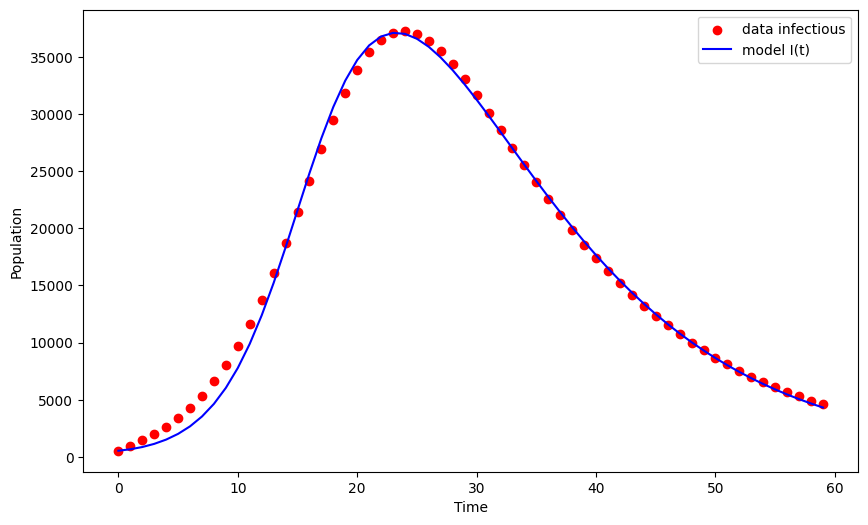



--- Optimal Parameters ---
beta  : 1.187
gamma : 0.084
sigma : 0.142
E0    : 999.979


In [ ]:
# Excel file path and sheet name
file_path = "/content/Simulation_Results_Main_Countries.xlsx"
sheet_name = "China"  # (China, Germany, Iran, Italy)

# Set total population N
N = 90000

# Boundary for (beta, gamma, sigma, E0)
upper_bounds = (2, 2, 1, 1000)


### -------------------------------------  ###

# Call a dataset for data fitting
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Set parameters that applies to the observed region
T = len(df)         # time for simulation (in days)
dt = 1
num_steps = int(T / dt)
a = 1/(365*70)
mu = 1/(365*70)


# Selecting good initial guess
print_result = False
nnn = 1000
init_guess = sobol_seq.i4_sobol_generate(4, nnn)
for (i, upper_bound) in enumerate(upper_bounds):
    init_guess[:,i] = init_guess[:,i] * upper_bound

# Optimizing cost_function
cost_list = [cost_fun(init_guess[f,:]) for f in range(0,nnn)]
min_guess = init_guess[cost_list.index(min(cost_list)),:]

print_result = True
bounds = [(0, upper_bound) for upper_bound in upper_bounds]
result = minimize(cost_fun, min_guess, bounds=bounds, method="powell")


# Extract the optimal parameters and SEIR solutions
optimal_parameters = result.x
[S,E,I,R] = ode45_sys(*optimal_parameters)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(T), df["I"], label='data infectious', color="red")
plt.plot(range(T), I, label='model I(t)', color="blue")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Display the optimal parameters
print('\n\n--- Optimal Parameters ---')
print(f'beta  : {optimal_parameters[0]:.3f}')
print(f'gamma : {optimal_parameters[1]:.3f}')
print(f'sigma : {optimal_parameters[2]:.3f}')
print(f'E0    : {optimal_parameters[3]:.3f}')

#### MSE dan RMSE

In [ ]:
import numpy as np

# Data observasi (df["I"]) dan data simulasi (I)
observed_data = df["I"]
simulated_data = I

# Menghitung selisih antara data observasi dan hasil simulasi
residuals = observed_data - simulated_data

# Menghitung MSE (Mean Squared Error)
mse = np.mean(residuals ** 2)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Menampilkan hasil
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')


MSE: 589317.22
RMSE: 767.67


### Iran

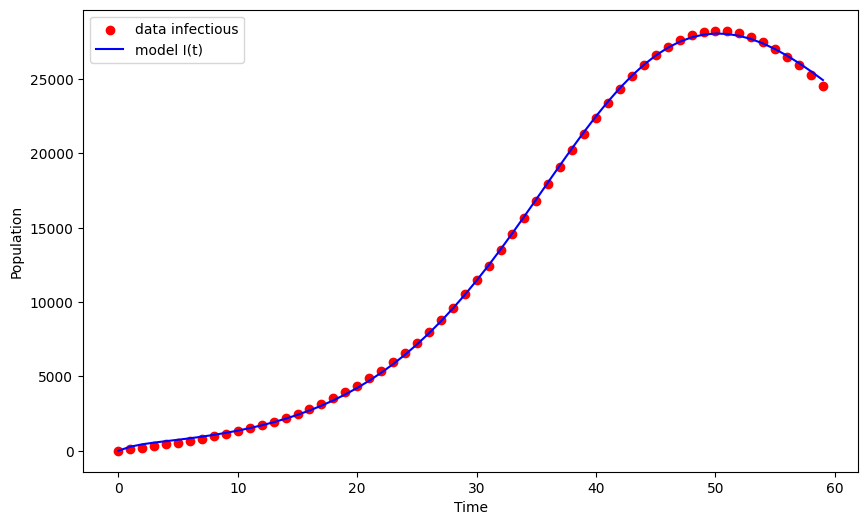



--- Optimal Parameters ---
beta  : 0.211
gamma : 0.054
sigma : 0.583
E0    : 619.761


In [ ]:
# Excel file path and sheet name
file_path = "/content/Simulation_Results_Main_Countries.xlsx"
sheet_name = "Iran"  # (China, Germany, Iran, Italy)

# Set total population N
N = 78000

# Boundary for (beta, gamma, sigma, E0)
upper_bounds = (3, 1, 1, 1000)


### -------------------------------------  ###

# Call a dataset for data fitting
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Set parameters that applies to the observed region
T = len(df)         # time for simulation (in days)
dt = 1
num_steps = int(T / dt)
a = 1/(365*70)
mu = 1/(365*70)


# Selecting good initial guess
print_result = False
nnn = 1000
init_guess = sobol_seq.i4_sobol_generate(4, nnn)
for (i, upper_bound) in enumerate(upper_bounds):
    init_guess[:,i] = init_guess[:,i] * upper_bound

# Optimizing cost_function
cost_list = [cost_fun(init_guess[f,:]) for f in range(0,nnn)]
min_guess = init_guess[cost_list.index(min(cost_list)),:]

print_result = True
bounds = [(0, upper_bound) for upper_bound in upper_bounds]
result = minimize(cost_fun, min_guess, bounds=bounds, method="powell")


# Extract the optimal parameters and SEIR solutions
optimal_parameters = result.x
[S,E,I,R] = ode45_sys(*optimal_parameters)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(T), df["I"], label='data infectious', color="red")
plt.plot(range(T), I, label='model I(t)', color="blue")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Display the optimal parameters
print('\n\n--- Optimal Parameters ---')
print(f'beta  : {optimal_parameters[0]:.3f}')
print(f'gamma : {optimal_parameters[1]:.3f}')
print(f'sigma : {optimal_parameters[2]:.3f}')
print(f'E0    : {optimal_parameters[3]:.3f}')

#### MSE dan RMSE

In [ ]:
import numpy as np

# Data observasi (df["I"]) dan data simulasi (I)
observed_data = df["I"]
simulated_data = I

# Menghitung selisih antara data observasi dan hasil simulasi
residuals = observed_data - simulated_data

# Menghitung MSE (Mean Squared Error)
mse = np.mean(residuals ** 2)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Menampilkan hasil
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MSE: 18901.28
RMSE: 137.48


### Italy

<ipython-input-3-0844060f63f0>:3: RuntimeWarning: overflow encountered in double_scalars
  dSdt = a*N - beta * S * I / N - mu*S
<ipython-input-3-0844060f63f0>:4: RuntimeWarning: overflow encountered in double_scalars
  dEdt = beta * S * I / N - sigma * E - mu*E
<ipython-input-3-0844060f63f0>:3: RuntimeWarning: invalid value encountered in double_scalars
  dSdt = a*N - beta * S * I / N - mu*S
<ipython-input-3-0844060f63f0>:4: RuntimeWarning: invalid value encountered in double_scalars
  dEdt = beta * S * I / N - sigma * E - mu*E
<ipython-input-3-0844060f63f0>:38: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = S[i - 1] + (dt / 6.0) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
<ipython-input-3-0844060f63f0>:39: RuntimeWarning: invalid value encountered in double_scalars
  E[i] = E[i - 1] + (dt / 6.0) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
<ipython-input-3-0844060f63f0>:40: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = I[i - 1] + (dt / 6.0) * (k

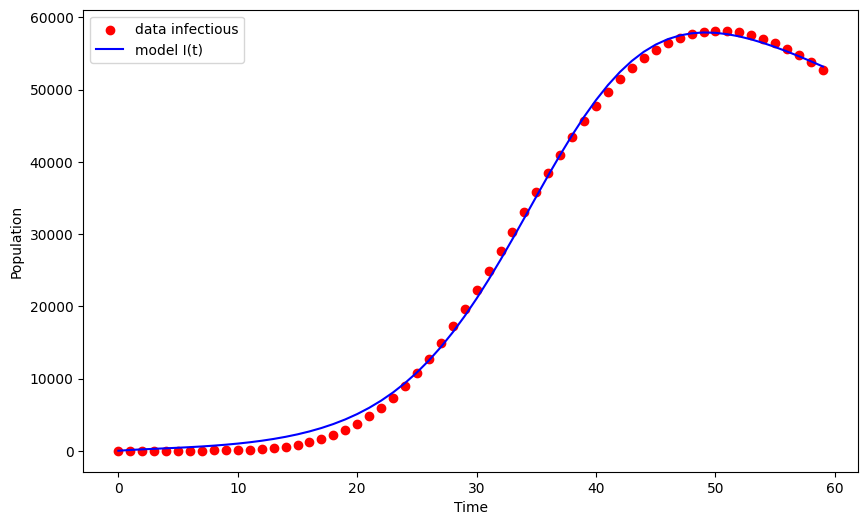



--- Optimal Parameters ---
beta  : 0.286
gamma : 0.017
sigma : 0.315
E0    : 388.912


In [ ]:
# Excel file path and sheet name
file_path = "/content/Simulation_Results_Main_Countries.xlsx"
sheet_name = "Italy"  # (China, Germany, Iran, Italy)

# Set total population N
N = 80000

# Boundary for (beta, gamma, sigma, E0)
upper_bounds = (1, 3, 1, 1000)


### -------------------------------------  ###

# Call a dataset for data fitting
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Set parameters that applies to the observed region
T = len(df)         # time for simulation (in days)
dt = 1
num_steps = int(T / dt)
a = 1/(365*70)
mu = 1/(365*70)


# Selecting good initial guess
print_result = False
nnn = 1000
init_guess = sobol_seq.i4_sobol_generate(4, nnn)
for (i, upper_bound) in enumerate(upper_bounds):
    init_guess[:,i] = init_guess[:,i] * upper_bound

# Optimizing cost_function
cost_list = [cost_fun(init_guess[f,:]) for f in range(0,nnn)]
min_guess = init_guess[cost_list.index(min(cost_list)),:]

print_result = True
bounds = [(0, upper_bound) for upper_bound in upper_bounds]
result = minimize(cost_fun, min_guess, bounds=bounds, method="powell")


# Extract the optimal parameters and SEIR solutions
optimal_parameters = result.x
[S,E,I,R] = ode45_sys(*optimal_parameters)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(T), df["I"], label='data infectious', color="red")
plt.plot(range(T), I, label='model I(t)', color="blue")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

# Display the optimal parameters
print('\n\n--- Optimal Parameters ---')
print(f'beta  : {optimal_parameters[0]:.3f}')
print(f'gamma : {optimal_parameters[1]:.3f}')
print(f'sigma : {optimal_parameters[2]:.3f}')
print(f'E0    : {optimal_parameters[3]:.3f}')

#### MSE dan RMSE

In [ ]:
import numpy as np

# Data observasi (df["I"]) dan data simulasi (I)
observed_data = df["I"]
simulated_data = I

# Menghitung selisih antara data observasi dan hasil simulasi
residuals = observed_data - simulated_data

# Menghitung MSE (Mean Squared Error)
mse = np.mean(residuals ** 2)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Menampilkan hasil
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')


MSE: 678363.88
RMSE: 823.63
